## Ordenar por y e depois por x

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from artlib import FuzzyART, FuzzyARTMAP, FusionART, VAT
from torch.utils.data import DataLoader
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
import time

In [10]:
# -----------------------------------------------------------
# Load USPS datasets
# -----------------------------------------------------------
train_data = USPS(root='./USPS/', train=True, download=True)
test_data  = USPS(root='./USPS/', train=False, download=True)

# Train
X_train = train_data.data                  # numpy, (N, 16, 16)
y_train = np.array(train_data.targets)
X_train_flat = X_train.reshape(len(X_train), -1)

# Test
X_test = test_data.data
y_test = np.array(test_data.targets)
X_test_flat = X_test.reshape(len(X_test), -1)


# -----------------------------------------------------------
# Function: sort samples by class and apply VAT inside each class
# -----------------------------------------------------------
def vat_by_class(X, y):
    X_vat_all = []
    y_vat_all = []

    num_classes = len(np.unique(y))

    for c in range(num_classes):
        # samples of class c
        mask = (y == c)
        X_c = X[mask]
        y_c = y[mask]

        print(f"Class {c} → {len(X_c)} samples")

        # apply VAT to class c only
        _, vat_indices = VAT(X_c)

        # reorder class c
        X_c_vat = X_c[vat_indices]
        y_c_vat = y_c[vat_indices]

        # accumulate
        X_vat_all.append(X_c_vat)
        y_vat_all.append(y_c_vat)

    # concatenate in class order
    return np.vstack(X_vat_all), np.concatenate(y_vat_all)


# -----------------------------------------------------------
# Apply VAT per class to train and test separately
# -----------------------------------------------------------
X_train_vat, y_train_vat = vat_by_class(X_train_flat, y_train)
X_test_vat,  y_test_vat  = vat_by_class(X_test_flat,  y_test)

print("\nFinal shapes:")
print("X_train_vat:", X_train_vat.shape)
print("y_train_vat:", y_train_vat.shape)
print("X_test_vat:",  X_test_vat.shape)
print("y_test_vat:",  y_test_vat.shape)


Class 0 → 1194 samples
Class 1 → 1005 samples
Class 2 → 731 samples
Class 3 → 658 samples
Class 4 → 652 samples
Class 5 → 556 samples
Class 6 → 664 samples
Class 7 → 645 samples
Class 8 → 542 samples
Class 9 → 644 samples
Class 0 → 359 samples
Class 1 → 264 samples
Class 2 → 198 samples
Class 3 → 166 samples
Class 4 → 200 samples
Class 5 → 160 samples
Class 6 → 170 samples
Class 7 → 147 samples
Class 8 → 166 samples
Class 9 → 177 samples

Final shapes:
X_train_vat: (7291, 256)
y_train_vat: (7291,)
X_test_vat: (2007, 256)
y_test_vat: (2007,)


In [11]:
# as imagens do conjunto são 16x16
n_dim = 16 * 16

#flatten images
X_train = X_train.reshape(-1, n_dim)
X_test = X_test.reshape(-1, n_dim)

In [12]:
# modelo FuzzyART
fuzzy_art_model = FuzzyART(rho=0.5, alpha=0.0, beta=1.0)

# modelo FuzzyARTMAP
fuzzy_artmap_model = FuzzyARTMAP(rho=0.9, alpha=0.0, beta=1.0)

# modelo FusionART

fusion_art_module_1 = FuzzyART(rho=0.5, alpha=0.0, beta=1.0)
fusion_art_module_2 = FuzzyART(rho=0.5, alpha=0.0, beta=1.0)
fusion_art_model = FusionART(modules=[fusion_art_module_1, fusion_art_module_2], gamma_values=[0.5,0.5], channel_dims=[256, 256])

In [13]:
# estabelecendo as bounds do modelo
lower_bounds = np.zeros(n_dim)
upper_bounds = np.full(n_dim, 255.0)

# bounds dos módulos do fusion art
module_lower_bounds = np.zeros(128)
module_upper_bounds = np.full(128, 255.0)

fuzzy_art_model.set_data_bounds(lower_bounds, upper_bounds)
fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)
fusion_art_module_1.set_data_bounds(module_lower_bounds, module_upper_bounds)
fusion_art_module_2.set_data_bounds(module_lower_bounds, module_upper_bounds)
fusion_art_model.set_data_bounds(lower_bounds, upper_bounds)

In [14]:
def calculate_average_accuracy(acc_matrix):
  num_tasks = acc_matrix.shape[0]
  if num_tasks == 0:
      return 0.0

  total_sum = 0.0
  count = 0

  for i in range(num_tasks):
    for j in range(i+1):
      total_sum += acc_matrix[i,j]
      count +=1

  return total_sum / count

def calculate_bwt(acc_matrix):
  num_tasks = acc_matrix.shape[0]
  if num_tasks <= 1:
      return 0.0

  bwt_sum = 0.0


  for j in range(num_tasks - 1):
      final_acc = acc_matrix[num_tasks - 1, j]
      initial_acc = acc_matrix[j, j]
      bwt_sum += (final_acc - initial_acc)

  bwt = bwt_sum / (num_tasks * (num_tasks - 1))/2

  return bwt

def calculate_fwt(acc_matrix):
    num_tasks = acc_matrix.shape[0]
    if num_tasks <= 1:
        return 0.0

    fwt_sum = 0.0
    base_acc = 0.0

    for j in range(1, num_tasks):
        fwd_acc = acc_matrix[j - 1, j]

        fwt_sum += (fwd_acc - base_acc)

    return fwt_sum / (num_tasks * (num_tasks - 1))/2

--- Iniciando o Experimento de Aprendizado Contínuo ---

--- Tarefa 1/10: Treinando com a classe: 1 ---
  > Testando nas classes: [1]
    > (Treino 1) Teste na classe 1 (Tarefa 1): ACC=1.0000
    > (Treino 1) Teste na classe 2 (Tarefa 2): ACC=0.0000
    > (Treino 1) Teste na classe 3 (Tarefa 3): ACC=0.0000
    > (Treino 1) Teste na classe 4 (Tarefa 4): ACC=0.0000
    > (Treino 1) Teste na classe 5 (Tarefa 5): ACC=0.0000
    > (Treino 1) Teste na classe 6 (Tarefa 6): ACC=0.0000
    > (Treino 1) Teste na classe 7 (Tarefa 7): ACC=0.0000
    > (Treino 1) Teste na classe 8 (Tarefa 8): ACC=0.0000
    > (Treino 1) Teste na classe 9 (Tarefa 9): ACC=0.0000
    > (Treino 1) Teste na classe 0 (Tarefa 10): ACC=0.0000
  > ARI Fuzzy (Classes [1]): 1.0000
  > ARI Fusion (Classes [1]): 1.0000

--- Tarefa 2/10: Treinando com a classe: 2 ---
  > Testando nas classes: [1, 2]
    > (Treino 2) Teste na classe 1 (Tarefa 1): ACC=0.9886
    > (Treino 2) Teste na classe 2 (Tarefa 2): ACC=0.9949
    > (Treino 2

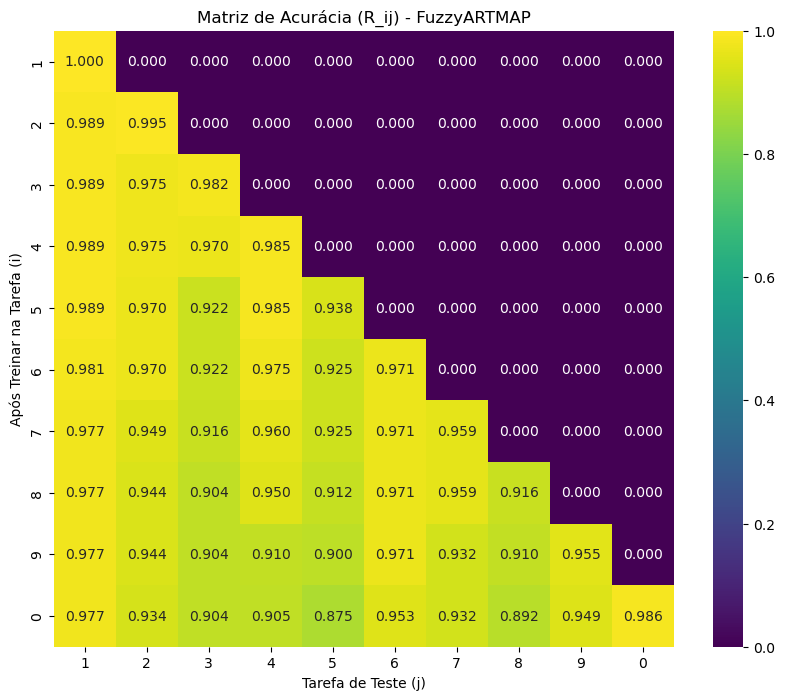

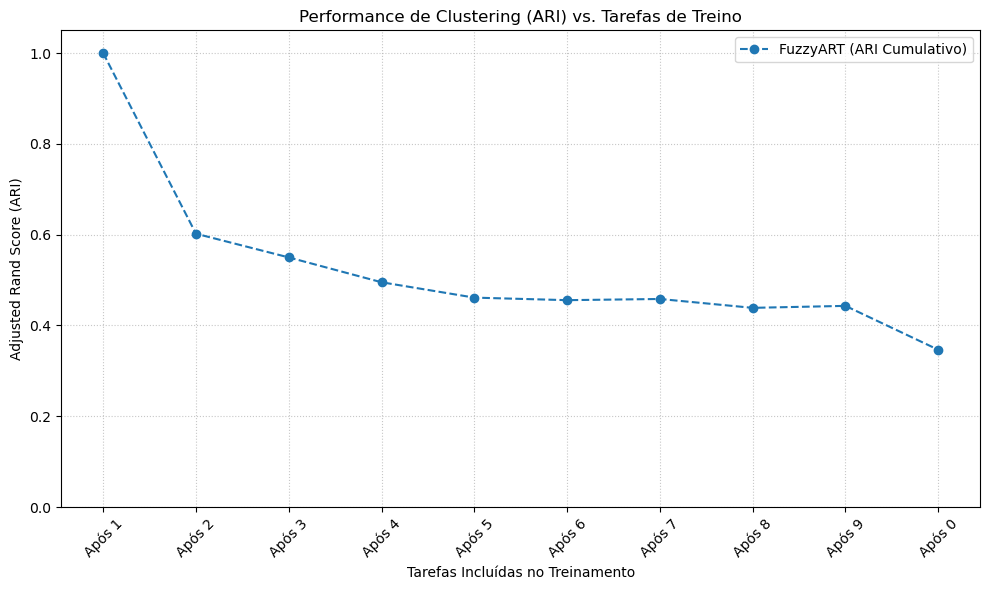

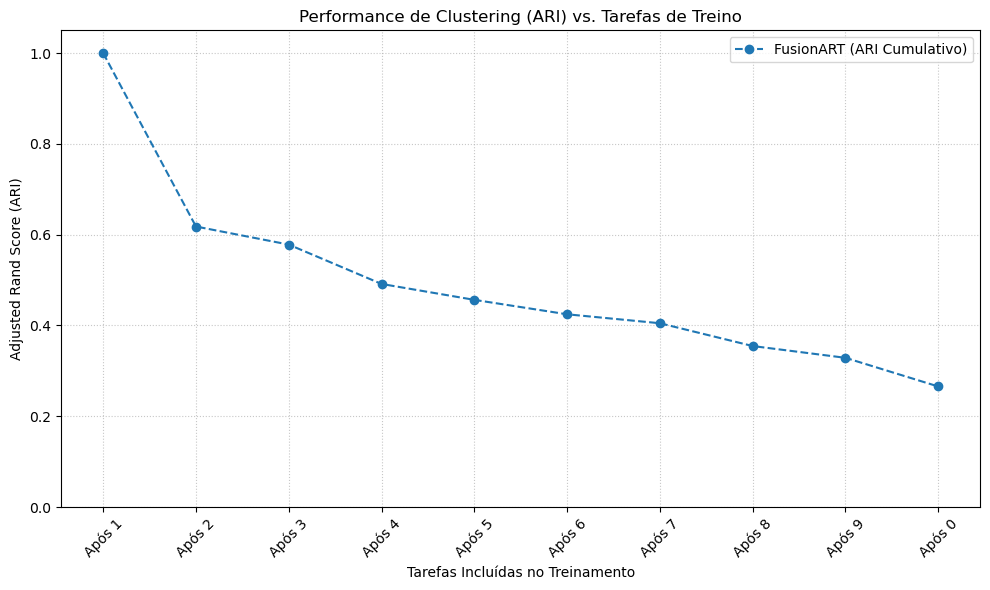

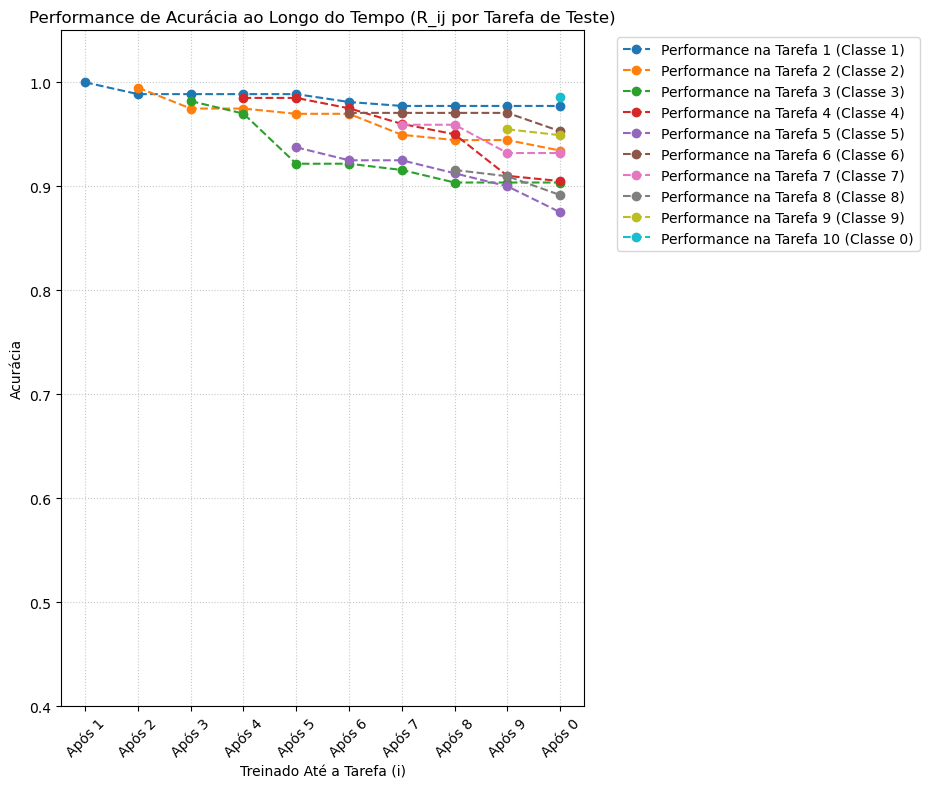

Acurácia Média (A): 0.9508
Backward Transfer (BWT): -0.0021
Forward Transfer (FWT): 0.0000


In [18]:
class_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
num_tasks = len(class_order)

acc_matrix = np.full((num_tasks, num_tasks), np.nan)
ari_scores_fuzzy_art = []
ari_scores_fusion_art = []

classes_seen_so_far = []

print("--- Iniciando o Experimento de Aprendizado Contínuo ---")

for i in range(num_tasks):
    current_train_class = class_order[i]
    classes_seen_so_far.append(current_train_class)

    print(f"\n--- Tarefa {i+1}/10: Treinando com a classe: {current_train_class} ---")

    mask_train = (y_train_vat == current_train_class)
    X_train_class_np = X_train_vat[mask_train].reshape(-1, n_dim)
    y_train_class_np = y_train_vat[mask_train]

    # ordenação pelo VAT
    #d_X_train = pairwise_distances(X_train_class_np, metric='euclidean')

    #sorted_samples_index = vat_ordering(d_X_train)
    #X_train_class_np = X_train_class_np[sorted_samples_index]
    #X_train_class_np = y_train[sorted_samples_index]

    X_train_fuzzy_art = fuzzy_art_model.prepare_data(X_train_class_np)
    X_train_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_class_np)

    X_train_ch1 = X_train_class_np[:, :128]
    X_train_ch2 = X_train_class_np[:, 128:]

    X_train_fa_ch1 = fusion_art_module_1.prepare_data(X_train_ch1)
    X_train_fa_ch2 = fusion_art_module_2.prepare_data(X_train_ch2)
    X_train_fusion_art = fusion_art_model.join_channel_data([X_train_fa_ch1, X_train_fa_ch2])

    fuzzy_art_model.partial_fit(X_train_fuzzy_art)
    fuzzy_artmap_model.partial_fit(X_train_fuzzy_artmap, y_train_class_np)
    fusion_art_model.partial_fit(X_train_fusion_art)

    print(f"  > Testando nas classes: {classes_seen_so_far}")
    for j in range(num_tasks):
        current_test_class = class_order[j]

        mask_test = (y_test_vat == current_test_class)
        X_test_class_np = X_test_vat[mask_test].reshape(-1, n_dim)
        y_test_class_np = y_test_vat[mask_test]

        X_test_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test_class_np)

        y_pred_fam = fuzzy_artmap_model.predict(X_test_fuzzy_artmap)

        acc = accuracy_score(y_test_class_np, y_pred_fam)

        acc_matrix[i][j] = acc
        print(f"    > (Treino {i+1}) Teste na classe {current_test_class} (Tarefa {j+1}): ACC={acc:.4f}")

    mask_test_cumulative = np.isin(y_test_vat, classes_seen_so_far)

    X_test_cumulative_np = X_test_vat[mask_test_cumulative].reshape(-1, n_dim)
    y_test_cumulative_np = y_test_vat[mask_test_cumulative]

    X_test_fuzzy_art = fuzzy_art_model.prepare_data(X_test_cumulative_np)

    y_pred_fuzzy_art = fuzzy_art_model.predict(X_test_fuzzy_art)

    X_test_ch1 = X_test_cumulative_np[:, :128]
    X_test_ch2 = X_test_cumulative_np[:, 128:]

    X_test_fa_ch1 = fusion_art_module_1.prepare_data(X_test_ch1)
    X_test_fa_ch2 = fusion_art_module_2.prepare_data(X_test_ch2)
    X_test_fusion_art = fusion_art_model.join_channel_data(channel_data=[X_test_fa_ch1, X_test_fa_ch2])

    y_pred_fusion_art = fusion_art_model.predict(X_test_fusion_art)

    ari_fuzzy = adjusted_rand_score(y_test_cumulative_np, y_pred_fuzzy_art)
    ari_fusion = adjusted_rand_score(y_test_cumulative_np, y_pred_fusion_art)
    ari_scores_fuzzy_art.append(ari_fuzzy)
    ari_scores_fusion_art.append(ari_fusion)

    print(f"  > ARI Fuzzy (Classes {classes_seen_so_far}): {ari_fuzzy:.4f}")
    print(f"  > ARI Fusion (Classes {classes_seen_so_far}): {ari_fusion:.4f}")


print("\n--- Experimento Concluído ---")


print(f"Matriz de Acurácia Final (R_ij):\n{np.round(acc_matrix, 3)}")

plt.figure(figsize=(10, 8))
class_labels_str = [str(c) for c in class_order]
sns.heatmap(acc_matrix, annot=True, fmt=".3f",
            xticklabels=class_labels_str,
            yticklabels=class_labels_str,
            cmap="viridis")
plt.xlabel("Tarefa de Teste (j)")
plt.ylabel("Após Treinar na Tarefa (i)")
plt.title("Matriz de Acurácia (R_ij) - FuzzyARTMAP")
plt.show()


plt.figure(figsize=(10, 6))
x_axis_labels = [f"Após {c}" for c in class_order]
plt.plot(x_axis_labels, ari_scores_fuzzy_art, marker='o', linestyle='--', label='FuzzyART (ARI Cumulativo)')
plt.title('Performance de Clustering (ARI) vs. Tarefas de Treino')
plt.xlabel('Tarefas Incluídas no Treinamento')
plt.ylabel('Adjusted Rand Score (ARI)')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
x_axis_labels = [f"Após {c}" for c in class_order]
plt.plot(x_axis_labels, ari_scores_fusion_art, marker='o', linestyle='--', label='FusionART (ARI Cumulativo)')
plt.title('Performance de Clustering (ARI) vs. Tarefas de Treino')
plt.xlabel('Tarefas Incluídas no Treinamento')
plt.ylabel('Adjusted Rand Score (ARI)')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

x_axis_labels_tasks = [f"Após {c}" for c in class_order]

for j in range(num_tasks):

    accuracy_column = acc_matrix[:, j]


    plot_data = accuracy_column.copy()
    plot_data[0:j] = np.nan

    test_class_label = class_order[j]
    line_label = f"Performance na Tarefa {j+1} (Classe {test_class_label})"

    plt.plot(x_axis_labels_tasks, plot_data, marker='o', linestyle='--', label=line_label)

plt.title('Performance de Acurácia ao Longo do Tempo (R_ij por Tarefa de Teste)')
plt.xlabel('Treinado Até a Tarefa (i)')
plt.ylabel('Acurácia')
plt.ylim(0.4, 1.05)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

avg_accuracy = calculate_average_accuracy(acc_matrix)
backward_transfer = calculate_bwt(acc_matrix)
forward_transfer = calculate_fwt(acc_matrix)
print(f"Acurácia Média (A): {avg_accuracy:.4f}")
print(f"Backward Transfer (BWT): {backward_transfer:.4f}")
print(f"Forward Transfer (FWT): {forward_transfer:.4f}")